# Thomas Fire Land Cover Statistics

Author: Haylee Oyler

## About

This notebook explores land cover change after the 2017 Thomas Fire in Santa Barbara and Ventura Counties. 

## Data

### References

In [ ]:
# Load libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from shapely import box
from IPython.display import Image 
import scipy.stats as stats

# MPC 
import pystac_client
import planetary_computer

# Cal-adapt
import intake
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point


## Fire Perimeter Preparation

In [3]:
# Read CA fire perimeters for the year of interest
fire_perimeters = gpd.read_file(os.path.join('data',
                                            'California_Fire_Perimeters_2017',
                                            'California_Fire_Perimeters_2017.shp')
                                            )

# Filter to just the Thomas fire
thomas_fire = fire_perimeters[fire_perimeters['FIRE_NAME']=='THOMAS']

# Explore fire perimeter data
thomas_fire.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

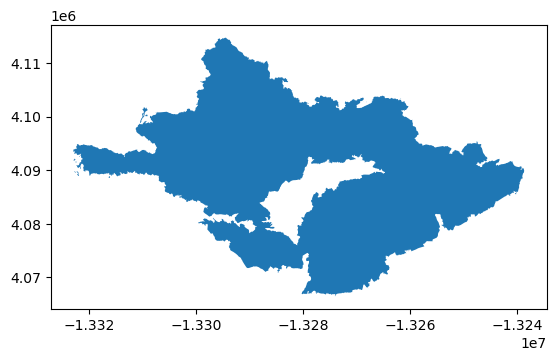

In [4]:
thomas_fire.plot()

## MPC Catalog Search

In [5]:
# Get bounding box for thomas fire 
thomas_fire_bbox = list(thomas_fire.to_crs('epsg:4326')
                                    .total_bounds
                                    )
thomas_fire_bbox

[-119.68162520650904,
 34.27989979600195,
 -118.92518097019486,
 34.63745683414112]

In [ ]:
# Open MPC data catalog connection
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)

# Search MPC catalog 
search = catalog.search(collections=['gap'], 
                        bbox=thomas_fire_bbox)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 1 Items


In [ ]:
# Extract the search item
item = items[0]  

# Display pre-rendered image
Image(url=item.assets['rendered_preview'].href, width=600)

We can see this raster is much larger than the extent of the thomas fire, but we are in the right location! 

Next, we'll import the csv with class labels from [DATA SOURCE]

In [8]:
labels = pd.read_csv(os.path.join('data', 'GAP_National_Terrestrial_Ecosystems.csv'))

labels.head()

class_label  code
0                                    0     0
1          South Florida Bayhead Swamp     1
2           South Florida Cypress Dome     2
3  South Florida Dwarf Cypress Savanna     3
4         South Florida Mangrove Swamp     4

## Explore Raster

In [9]:
# Access raster data from item
lulc = rioxr.open_rasterio(item.assets['data'].href)
lulc

<xarray.DataArray (band: 1, y: 10000, x: 10000)> Size: 200MB
[100000000 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 80kB -2.361e+06 -2.361e+06 ... -2.061e+06
  * y            (y) float64 80kB 1.762e+06 1.762e+06 ... 1.462e+06 1.462e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

In [10]:
# Remove length 1 dimension (band)
lulc = lulc.squeeze().drop_vars('band')
print("Sizes of dimensions:", dict(lulc.sizes))

Sizes of dimensions: {'y': 10000, 'x': 10000}


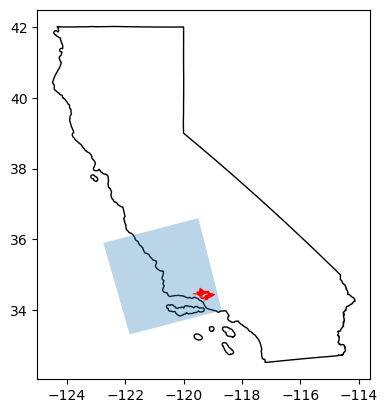

In [12]:
# Create GeoDataFrame from raster bounding box
lulc_bbox = gpd.GeoDataFrame(geometry = [box(*lulc.rio.bounds())],
                            crs = lulc.rio.crs)

ca = gpd.read_file(os.path.join('data',
                                'ca_state_boundary',   
                                'ca_state_boundary.shp'))

# ------------------------------------------------------------------
# Plot raster boundary, fire perimeter, and CA boundary
fig, ax = plt.subplots()
ca.plot(ax=ax, color='white', edgecolor ='black')

# Reproject lulc_bbox and fire perimeter to match CA crs
lulc_bbox.to_crs(ca.crs).plot(ax=ax, alpha=0.3)  
thomas_fire.to_crs(ca.crs).plot(ax=ax, color='red')

plt.show()

## Clip Raster to Geometry

/Users/hayleeoyler/miniforge3/envs/eds220-env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


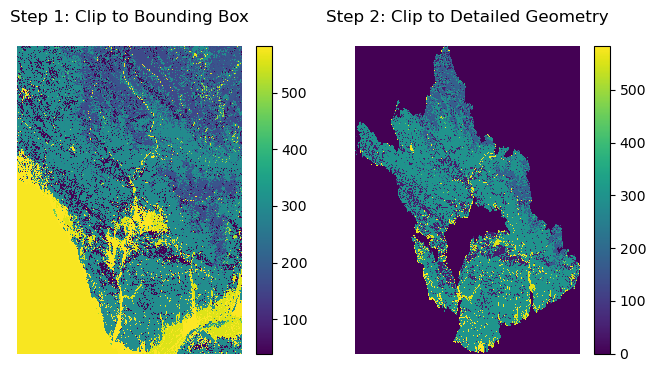

In [13]:
# Match CRSs and verify update
thomas_fire_match = thomas_fire.to_crs(lulc.rio.crs)
assert thomas_fire_match.crs == lulc.rio.crs

# Clip large raster to detailed geometry in two steps
lulc_step1 = lulc.rio.clip_box(*thomas_fire_match.total_bounds)
lulc_step2 = lulc_step1.rio.clip(thomas_fire_match.geometry)  # Produces RuntimeWarning

# ------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first clipped raster
lulc_step1.plot(ax=ax[0])
ax[0].set_title("Step 1: Clip to Bounding Box")
ax[0].axis("off")

# Plot the second clipped raster
lulc_step2.plot(ax=ax[1])
ax[1].set_title("Step 2: Clip to Detailed Geometry")
ax[1].axis("off")

plt.show()

Notice a RunTimeWarning appeared when we clipped the raster. This occurs because the `rio.clip()` function tries to fill values outside the fire perimeter with np.nan. However, as we previously saw, our raster’s data type is uint16 (16 bits unsigned integer). The cast issue appears since np.nan is a float (decimal number) and it cannot be casted as a uint16. To make sure the clipping operator fills in any pixels with the adequate no-data value, let’s manually set it:

In [14]:
print('Original no-data value: ', lulc.rio.nodata)

# Update raster's no-data value
lulc = lulc.rio.write_nodata(0)
print('Updated no-data value: ', lulc.rio.nodata)

Original no-data value:  None
Updated no-data value:  0


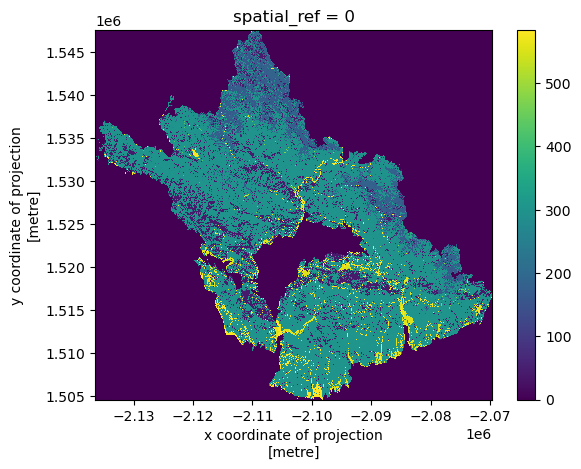

In [15]:
lulc_clip = (lulc.rio.clip_box(*thomas_fire_match.total_bounds)
                .rio.clip(thomas_fire_match.geometry)
                )

# Examine results
lulc_clip.plot()                                  

In [ ]:
# Get the number of pixels per class
values, counts = np.unique(lulc_clip, return_counts = True)

# 
np.repeat(values, counts)

array([  0,   0,   0, ..., 584, 584, 584], dtype=uint16)

In [21]:
counts

array([1927870,    6856,     361,  133704,    3638,   23150,    2907,
          4974,    3727,   60203,    5102,   75925,     378,   11098,
            29,      98,   64072,   69700,  183963,  454489,   88504,
           799,     750,     684,      28,      90,     865,     262,
          1329,      54,      44,      27,     298,      24,      15,
            43,       7,   18996,    2181,     485,      13,      20,
            10,    1858,   40653,    3782,     829,      58])

In [24]:
pix_counts = pd.DataFrame({
    'class' : values,
    'pixel_count' : counts,
})

pix_counts.head()

class  pixel_count
0      0      1927870
1     39         6856
2     40          361
3     41       133704
4     42         3638

Use the labels data frame to add the class names to the codes in the pix_counts data frame. Store the resulting data frame as classes.

## Cal-Adapt Climate Data

In [ ]:
# Open the Cal-Adapt data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cadcat.s3.amazonaws.com/cae-collection.json')

# Print the associated data frame
print(catalog.df)

In [ ]:
# Print out all unique grid labels
print(catalog.df.grid_label.unique())

# Print out all unique variable_id values
print(catalog.df.variable_id.unique())

# Print out all unique table_id values
print(catalog.df.table_id.unique())

cat_df = catalog.df

# Display all the variables available at different time resolutions
# daily
print(cat_df[cat_df["table_id"] == "day"].variable_id.unique())

# monthly
print(cat_df[cat_df["table_id"] == "mon"].variable_id.unique())


In [ ]:
# Specify search terms to query catalog 
# activity_id: which downscaling technique do you want?
activity_id = ["LOCA2"]

# experiment_id: which historical/future scenario do you want?
experiment_ids = ["historical", "ssp370"]

# table_id: which time resolution do you want?
table_id = ["day"]

# variable_id: which variable do you want?
variable_id = ["pr"]

In [ ]:
# Search through catalog, store results
loca_res = catalog.search(activity_id=activity_id, experiment_id=experiment_ids,
                     table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(loca_res.df)

# Display unique models 
print(loca_res.df.source_id.unique())

# Display unique models 
print(wrf_res.df.source_id.unique())

# Compare them with the LOCA2 model list
print(loca_res.df.source_id.unique())

In [ ]:
# Display unique variables 
print(wrf_res.df.variable_id.unique())

In [ ]:
# Extract the CESM2 data in the WRF catalog data frame
cesm2_wrf_df = wrf_res.df[(wrf_res.df["source_id"] == "CESM2")]

# Extract the "prec" data field from the CESM2 data frame                          
prec_cesm2df = cesm2_wrf_df[(cesm2_wrf_df["variable_id"] == "prec")]

# Print results
print(prec_cesm2df)

In [ ]:
# Read in first entry, display metadata
test_data = xr.open_zarr(prec_cesm2df['path'].iloc[0], storage_options={'anon': True})

In [ ]:
# Display the contents of the "prec" variable
test_data.prec

In [ ]:
# Subset the LOCA2 data frame to use only the CESM2 information
loca_df = loca_res.df

# CESM2 historical
cesm2_loca_histdf = loca_df[(loca_df["source_id"] == "CESM2-LENS") & (loca_df["experiment_id"] == "historical")]

# CESM2 SSP3-7.0
cesm2_loca_sspdf = loca_df[(loca_df["source_id"] == "CESM2-LENS") & (loca_df["experiment_id"] == "ssp370")]

In [ ]:
# Make a list of the unique ensemble members
# historical
mems_hist = cesm2_loca_histdf.member_id.unique()
# SSP
mems_ssp = cesm2_loca_sspdf.member_id.unique()

# Convert these to sets, find the intersection between them, and convert back to a list
common_mems = list(set(mems_hist) & set(mems_ssp))

print(common_mems)

In [ ]:
# Define an empty list
cesm2_loca_data = []

# Loop over all common ensemble members
for mem in range(len(common_mems)):
    print(common_mems[mem])

    # True/False array showing whether or not the member_id matches our member of interest
    hist_mask = cesm2_loca_histdf['member_id'] == common_mems[mem]
    # extract (first) location where the mask is True
    hist_loc = cesm2_loca_histdf['member_id'][hist_mask].index[0]
    
    # Do the same thing for the SSP ensemble
    ssp_mask = cesm2_loca_sspdf['member_id'] == common_mems[mem]
    ssp_loc = cesm2_loca_sspdf['member_id'][ssp_mask].index[0]
    
    # Store HISTORICAL data as xarray
    hist_data = xr.open_zarr(cesm2_loca_histdf['path'][hist_loc], storage_options={'anon': True})
    
    # Store SSP3-7.0 data as xarray
    ssp_data = xr.open_zarr(cesm2_loca_sspdf['path'][ssp_loc], storage_options={'anon': True})
    
    # Concatenate historical, SSP information
    temp_data = xr.concat([hist_data, ssp_data], dim="time")
    
    # Add to list
    cesm2_loca_data.append(temp_data)

# Concatenate the list into a single xarray object
cesm2_loca_data = xr.concat(cesm2_loca_data, dim="member")

# Store the actual member information as values of the new dimension
cesm2_loca_data = cesm2_loca_data.assign_coords(member=("member", common_mems))

In [ ]:
# Print xarray object
print(cesm2_loca_data)

In [ ]:
# Get data for an earlier period
cesm2_locadata_early = cesm2_loca_data.sel(time=slice("1981-01-01", "2010-12-31"))
cesm2_wrfdata_early = cesm2_wrf_data.sel(time=slice("1981-01-01", "2010-12-31"))

# Get data for a later period
cesm2_locadata_late = cesm2_loca_data.sel(time=slice("2071-01-01", "2100-12-31"))
cesm2_wrfdata_late = cesm2_wrf_data.sel(time=slice("2071-01-01", "2100-12-31"))

# Calculate the differences
cesm2_loca_diff = cesm2_locadata_late.mean(dim="time") - cesm2_locadata_early.mean(dim="time")
cesm2_wrf_diff = cesm2_wrfdata_late.mean(dim="time") - cesm2_wrfdata_early.mean(dim="time")

In [ ]:
# Calculate the ensemble means
cesm2_loca_diff = cesm2_loca_diff.mean(dim="member")
cesm2_wrf_diff = cesm2_wrf_diff.mean(dim="member")


In [ ]:
# Extract LOCA2 values into a Numpy array
cesm2_loca_diff_pr = cesm2_loca_diff.pr.values

# Extract WRF values into a Numpy array
cesm2_wrf_diff_pr = cesm2_wrf_diff.prec.values


In [ ]:
# Display units for LOCA2, WRF data
print(cesm2_locadata_late.pr.units)

print(cesm2_wrfdata_late.prec.units)

In [ ]:
# Convert LOCA2 values to mm/day
cesm2_loca_diff_pr = cesm2_loca_diff_pr * 86400

In [ ]:
map = ccrs.PlateCarree()

# Make a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(24, 10), subplot_kw={"projection": map})

# Subplot 1: LOCA2
plot1 = axes[0].pcolormesh(cesm2_loca_diff.lon, cesm2_loca_diff.lat, cesm2_loca_diff_pr, 
                           transform=map, cmap="BrBG", vmin=-1.5, vmax=1.5)

# Add coastlines, state borders, and gridlines
axes[0].add_feature(cfeature.COASTLINE)
axes[0].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot1, ax=axes[0], orientation='vertical', pad=0.05)
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0].set_title("CESM2 LOCA2 precip (late-century - historical)", fontsize=18)

# Subplot 2: WRF
plot2 = axes[1].pcolormesh(cesm2_wrf_diff.lon, cesm2_wrf_diff.lat, cesm2_wrf_diff_pr, 
                           transform=map, cmap="BrBG", vmin=-1.5, vmax=1.5)

# Add coastlines, state borders, and gridlines
axes[1].add_feature(cfeature.COASTLINE)
axes[1].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot2, ax=axes[1], orientation='vertical', pad=0.05)
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1].set_title("CESM2 WRF precip (late-century - historical)", fontsize=18)


In [ ]:
# Read in shapefile for CA counties
gdf = gpd.read_file('ca_counties/CA_Counties.shp')

# Reproject the shapefile to use the PlateCarree projection
gdf = gdf.to_crs(epsg=4326)

In [ ]:
map = ccrs.PlateCarree()

# Make a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(24, 10), subplot_kw={"projection": map})

# Subplot 1: LOCA2
plot1 = axes[0].pcolormesh(cesm2_loca_diff.lon, cesm2_loca_diff.lat, cesm2_loca_diff_pr, 
                           transform=map, cmap="BrBG", vmin=-1.5, vmax=1.5)

# Add coastlines, borders, and gridlines
axes[0].add_feature(cfeature.COASTLINE)
axes[0].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot1, ax=axes[0], orientation='vertical', pad=0.05)
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0].set_title("CESM2 LOCA2 precip (late-century - historical)", fontsize=18)

# Add county shape file
gdf.plot(ax=axes[0], facecolor='none', edgecolor='black', lw=1)

# Subplot 2: WRF
plot2 = axes[1].pcolormesh(cesm2_wrf_diff.lon, cesm2_wrf_diff.lat, cesm2_wrf_diff_pr, 
                           transform=map, cmap="BrBG", vmin=-1.5, vmax=1.5)

# Add coastlines, borders, and gridlines
axes[1].add_feature(cfeature.COASTLINE)
axes[1].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot2, ax=axes[1], orientation='vertical', pad=0.05)
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1].set_title("CESM2 WRF precip (late-century - historical)", fontsize=18)

# Add county shape file
gdf.plot(ax=axes[1], facecolor='none', edgecolor='black', lw=1)


